In [1]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [2]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# import data directly from google sheets

In [3]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [4]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [5]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [64]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [65]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [66]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [67]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# projects by country, by region

In [10]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_country_df[status] = country_ratios_oil_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [11]:
num_by_region_df

,Proposed,Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Australia and New Zealand,12590.05,580.00,334.28,6194.68,30991.82,0.0,0.00,0.00
East Asia,31379.31,26378.73,2067.66,1364.51,92288.71,0.0,0.00,41.00
Eurasia,18323.85,5153.09,272.69,5756.89,129176.25,0.0,3298.31,1783.24
Europe,17638.78,2836.19,5539.47,14017.44,121121.21,0.0,4735.18,823.06
Latin America and the Caribbean,12772.03,1304.00,2187.28,1301.39,39254.35,0.0,224.00,0.00
Middle East and North Africa,5333.55,7773.20,5964.34,4146.27,49700.91,0.0,1107.39,39.28
North America,10347.34,3087.20,10919.39,13277.01,420892.03,331.0,0.00,0.00
SE Asia,9222.66,984.30,2801.34,1423.82,16912.55,0.0,0.00,0.00
South Asia,4222.57,17113.79,6344.41,6141.07,29669.32,0.0,0.00,35.00
Sub-Saharan Africa,18833.16,1582.00,1678.16,176.96,7031.52,0.0,0.00,0.00


# numbers of pipes finished in a given year

In [12]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [13]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Gas')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [14]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Gas')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [15]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [16]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [17]:
pipes_indev_startyear.unstack()

StartYearEarliest,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0,2026.0,2027.0,2028.0,2029.0,2030.0,2034.0,2035.0,2046.0,NaN
Status,,,,,,,,,,,,,,,,,
Construction,873.0,NaN,NaN,34.76,28031.12,13428.02,5100.24,1957.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17579.25
Proposed,NaN,450.0,38.0,0.00,6153.72,8824.17,10180.17,9670.77,3499.17,3576.66,5323.74,942.0,5952.63,315.0,110.0,5660.0,79896.58
Shelved,NaN,221.7,1100.7,5159.62,3795.37,3353.45,1308.38,1169.99,NaN,150.00,636.00,135.0,NaN,NaN,NaN,NaN,21078.02


## Fig 2 - 2023–2030, go back to 2008

In [18]:
pandas.DataFrame(pipes_started_sum).to_excel('saved-tables/pipelines-operating-km-by-start-year.xlsx')

pandas.DataFrame(pipes_indev_startyear).unstack().replace(numpy.nan,0).to_excel('saved-tables/pipelines-indev-km-by-start-year.xlsx')

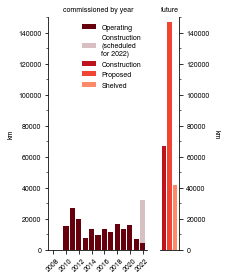

In [19]:
font_size = 7

ytop = 150000
ytop2 = 150000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    if s in ['Proposed','Shelved']:
        ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
                 color=c, label=s))
    else:
        ax2_list.append(ax2.bar(x, pipes_indev[s],
                 color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])


ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022.pdf', bbox_inches='tight', transparent=True)

## alt for David

In [20]:
pipes_indev

Status
Construction     67003.39
Proposed        140592.61
Shelved          38108.23
Name: LengthMergedKm, dtype: float64

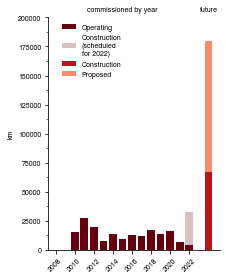

In [21]:
font_size = 7

ytop = 200000
ytop2 = 200000

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []
# for x,c,s in zip(xvals,colors,status):
#     if s in ['Proposed','Shelved']:
#         ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
#                  color=c, label=s))
#     else:
#         ax2_list.append(ax2.bar(x, pipes_indev[s],
#                  color=c, label=s))
ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2022],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

#ax2.yaxis.tick_right()
#ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
#ax2.yaxis.set_label_position('right')
ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022-alt.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022-alt.pdf', bbox_inches='tight', transparent=True)

In [22]:
pipes_indev

Status
Construction     67003.39
Proposed        140592.61
Shelved          38108.23
Name: LengthMergedKm, dtype: float64

## percent pipelines with start date (sanity check)

In [23]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [24]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.578544061302682

## regional pipelines started in given year

In [25]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [26]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [27]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

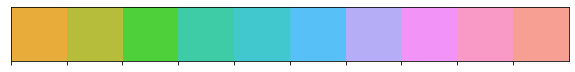

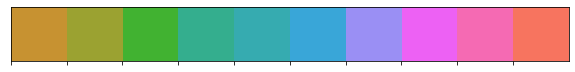

In [28]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

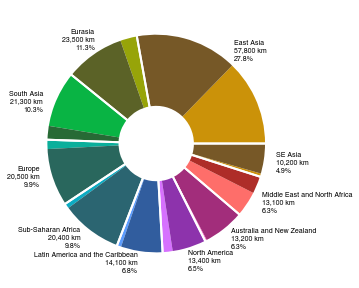

In [63]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/gas-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/gas-pipelines_pie-graph-country-pipelines-km.png', 
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

# top 20 countries proposed+construction

In [30]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

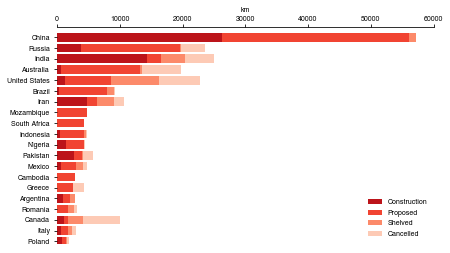

In [31]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/gas-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/gas-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

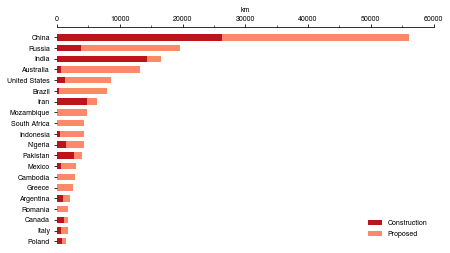

In [32]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/gas-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/gas-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [33]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.4025712154059584

# parent analysis

In [35]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas'].iterrows():
    parent_string = row.Parent
    print(parent_string)
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    for p_idx,parent in enumerate(parent_list):
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'Country':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'Status':row.Status,
                                                                         'LengthMergedKm':row.LengthMergedKm,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnership'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.LengthMergedKm
owner_parent_calculations_df['CapacityOwnership'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CapacityBOEd

Summit Group [70.00%]; ExxonMobil [30.00%]
Enterprise Products Partners [100.00%]
Enbridge [100.00%]
Enbridge [100.00%]
ExxonMobil [unknown %]; TC Energy [unknown %]
Alaska Gasline Development Corporation [100.00%]
Enbridge [100.00%]
Enbridge [100.00%]
Enbridge [50.00%]; Other [50.00%]
TC Energy [100.00%]
Williams Companies [100.00%]
Enbridge [100.00%]
Dominion Energy [45.00%]; Duke Energy [40.00%]; Piedmont Natural Gas [10.00%]; Southern Company Gas [5.00%]
Williams Companies [100.00%]
Enbridge [100.00%]
TC Energy [100.00%]
EnLink Midstream [unknown %]; Targa Resources [unknown %]
TC Energy [100.00%]
Enable Midstream Partners, LP [100.00%]
Enable Midstream Partners, LP [100.00%]
Enable Midstream Partners, LP [100.00%]
Enable Midstream Partners, LP [50.00%]; Enbridge [50.00%]
EnLink Midstream [100.00%]
El Paso Corporation [100.00%]
TC Energy [35.00%]; Alberta Investment Management Company [32.50%]; KKR Global Infrastructure Investors III [32.50%]
Kinder Morgan [100.00%]
TC Energy [100.

IndexError: index 0 is out of bounds for axis 0 with size 0

### companies invested in Russian infrastructure?

it's really just ProjectIDs 2044 (Caspian Oil Pipeline), 3675 (Vostok Oil Pipeline), and 3679 (Sabo-Dagi Oil Pipeline)

In [ ]:
# project IDs of pipelines that pass through Russia and are construction/proposed
russian_indev_projectids = country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['Proposed','Construction']))&
                                                     (country_ratios_oil_df.Country=='Russia')]['ProjectID'].unique()
#russian_indev_projectids
russian_indev_op_df = owner_parent_calculations_df.loc[owner_parent_calculations_df.ProjectID.isin(russian_indev_projectids)]
russian_indev_op_df.loc[russian_indev_op_df.Country!='Russia']



## biggest parent companies for in-dev stuff?

In [85]:
pandas.DataFrame(
    owner_parent_calculations_df.loc[
        owner_parent_calculations_df.Status.isin(['Proposed','Construction','Country'])].groupby(
        'Parent')['KmOwnership'].sum()).sort_values('KmOwnership', ascending=False)[:20]

KeyError: 'Column not found: KmOwnership'

In [86]:
pandas.DataFrame(
    owner_parent_calculations_df.loc[
        owner_parent_calculations_df.Status.isin(['Proposed','Construction'])].groupby(
        ['Parent','Country'])[['KmOwnership','CapacityOwnership']].sum(min_count=1)).sort_values('KmOwnership', ascending=False)[:20]

KeyError: "Columns not found: 'KmOwnership', 'CapacityOwnership'"

### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [112]:
# kuhne paper
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

In [113]:
# calculate the number of CapacityBOEd entries, and which of those are NaNs
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
pandas.set_option('display.max_colwidth', None)
result = owner_parent_calculations_df.loc[
    owner_parent_calculations_df.Status.isin(['Proposed','Construction'])].groupby(
    ['Parent','Country'])[['KmOwnership','CapacityBOEd','ProjectID']].agg({'KmOwnership':lambda x: x.sum(min_count=1),
                                                                           'CapacityBOEd':[lambda x: x.sum(min_count=1),
                                                                                           lambda x: x.dropna().count()],
                                                                           'ProjectID':[lambda x: list(x.unique()).__len__(),
                                                                                        lambda x: list(x.unique()),
                                                                                        lambda x: [pipes_df_orig.loc[pipes_df_orig.ProjectID==i]['PipelineName'] for i in x]
                                                                                                  ]})

result['HowManyProjectsHaveCapacityData'] = result[('CapacityBOEd','<lambda_1>')].astype(str) + ' of ' + result[('ProjectID','<lambda_0>')].astype(str)
result[['KmOwnership','CapacityBOEd','HowManyProjectsHaveCapacityData']].sort_values(('KmOwnership','<lambda>'), ascending=False)[:20]
result['EmissionsMtCO2PerYear'] = result[('CapacityBOEd','<lambda_0>')]*co2_rate/1e6

### total emissions globally (known capacity is at about 67%)

In [114]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

0.6551724137931034


4610.084677218931

In [115]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

0.6730769230769231


3336.5867548786496

In [116]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Gas')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

0.6285714285714286


1273.4979223402795

### count fraction of available capacity information

count

In [36]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Australia and New Zealand          23
East Asia                          91
Eurasia                            11
Europe                             43
Latin America and the Caribbean    29
Middle East and North Africa        8
North America                      15
SE Asia                             2
South Asia                         26
Sub-Saharan Africa                  6
Name: CapacityBOEd, dtype: int64

fraction

In [37]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
Latin America and the Caribbean,0.935
Australia and New Zealand,0.821
Eurasia,0.786
South Asia,0.703
East Asia,0.583
Middle East and North Africa,0.533
Europe,0.494
North America,0.469
Sub-Saharan Africa,0.273


In [38]:
median_capacity = pipes_df_orig['CapacityBcm/y'].median()

In [39]:
abs_dist_from_med_capacity = abs(pipes_df_orig['CapacityBcm/y']-pipes_df_orig['CapacityBcm/y'].median()).median()

In [40]:
pipes_df_orig['CapacityBcm/y'].mean()

246.5564427860697

In [41]:
pipes_df_orig['CapacityBcm/y'].std()

628.1353143829608

In [42]:
print(median_capacity)
print(abs_dist_from_med_capacity)

10.34
9.745000000000001


median capacity for a pipeline is about 10.34 bcm/y

median abs dist from the median is about 9.75.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

In [54]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Gas') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0) &
                                    (country_ratios_df['CostUSDPerKm']<10e6)
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [55]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2411610.589168704

### calculate regional costs

In [56]:
pipes_oil_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_oil_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_oil_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    #pipes_oil_costs_region_df.loc[region,'NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()


Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


In [57]:
country_ratios_region_df['CostUSDPerKm'].mean()

4001946.7805

In [58]:
pandas.options.display.float_format = '{:,.2f}'.format
temp_df = pipes_oil_costs_region_df
temp_df['CostUSDPerKm'] /= 1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.00,5
North America,3.47,133
Eurasia,2.93,41
Latin America and the Caribbean,2.87,23
Europe,2.49,111
SE Asia,2.37,8
Middle East and North Africa,2.22,35
South Asia,1.66,17
East Asia,1.45,54
Australia and New Zealand,1.31,10


In [59]:
pandas.options.display.float_format = '{:,.3f}'.format
pipes_oil_costs_region_df#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Australia and New Zealand,1.307,10
East Asia,1.446,54
Eurasia,2.933,41
Europe,2.488,111
Latin America and the Caribbean,2.869,23
Middle East and North Africa,2.224,35
North America,3.469,133
SE Asia,2.366,8
South Asia,1.663,17
Sub-Saharan Africa,4.002,5


### table for methodology with regional cost info

In [60]:
pipes_oil_costs_region_df

,CostUSDPerKm,DataPoints
Australia and New Zealand,1.307,10
East Asia,1.446,54
Eurasia,2.933,41
Europe,2.488,111
Latin America and the Caribbean,2.869,23
Middle East and North Africa,2.224,35
North America,3.469,133
SE Asia,2.366,8
South Asia,1.663,17
Sub-Saharan Africa,4.002,5


### calculate country-level costs

# tables etc.

## table for regional totals

In [62]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_36788/997741405.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_region_df = km_by_region_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,"31,379.310","26,378.730","57,758.040","2,067.660","1,364.510","92,288.710",0.000,0.000,41.000
Eurasia,"18,323.850","5,153.090","23,476.940",272.690,"5,756.890","129,176.250",0.000,"3,298.310","1,783.240"
South Asia,"4,222.570","17,113.790","21,336.360","6,344.410","6,141.070","29,669.320",0.000,0.000,35.000
Europe,"17,638.780","2,836.190","20,474.970","5,539.470","14,017.440","121,121.210",0.000,"4,735.180",823.060
Sub-Saharan Africa,"18,833.160","1,582.000","20,415.160","1,678.160",176.960,"7,031.520",0.000,0.000,0.000
Latin America and the Caribbean,"12,772.030","1,304.000","14,076.030","2,187.280","1,301.390","39,254.350",0.000,224.000,0.000
North America,"10,347.340","3,087.200","13,434.540","10,919.390","13,277.010","420,892.030",331.000,0.000,0.000
Australia and New Zealand,"12,590.050",580.000,"13,170.050",334.280,"6,194.680","30,991.820",0.000,0.000,0.000
Middle East and North Africa,"5,333.550","7,773.200","13,106.750","5,964.340","4,146.270","49,700.910",0.000,"1,107.390",39.280
SE Asia,"9,222.660",984.300,"10,206.960","2,801.340","1,423.820","16,912.550",0.000,0.000,0.000


## table for km by country

In [68]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/gas-pipelines-km-by-country.xlsx')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_36788/3713560636.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_country_df = km_by_country_df.append(total)


# table for stranded asset calculations

## country-level capex estimates

In [100]:
country_ratios_oil_df.reset_index(drop=True, inplace=True)
country_ratios_oil_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_oil_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_oil_df.loc[idx,'CostUSDEstimate'] = pipes_oil_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna())]['LengthKnownKmByCountry'] * \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna())]['CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_16870/2359184464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_oil_df.loc[:,'CostUSDEstimate'] = numpy.nan


In [101]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [102]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [103]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [104]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_16870/2444263024.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_region_df = capex_by_region_df.append(total)


In [105]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_16870/3950818690.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_country_df = capex_by_country_df.append(total)


In [106]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,71.1,7.7,78.7,30.3,65.3,51.0,0.0,0.0,0.0
Sub-Saharan Africa,32.1,2.9,35.0,0.0,0.0,0.0,0.0,0.0,0.0
Europe,30.3,4.3,34.7,14.4,13.4,58.0,0.0,0.0,0.0
Middle East and North Africa,18.1,13.7,31.7,0.6,2.7,25.2,0.0,0.0,0.0
Latin America and the Caribbean,18.1,0.1,18.1,6.7,0.0,0.0,0.0,0.0,0.0
Eurasia,13.2,1.1,14.4,1.1,6.7,87.7,0.0,0.0,0.0
South Asia,0.8,11.4,12.2,0.8,5.4,1.3,0.0,0.0,0.0
East Asia,5.3,2.7,8.0,0.0,2.1,6.0,0.0,0.0,0.0
Australia and New Zealand,7.2,0.0,7.2,0.0,0.1,0.7,0.0,0.0,0.0
SE Asia,3.2,1.3,4.5,0.3,0.0,0.0,0.0,0.0,0.0


## print out country-level stranded assets for report discussion

## in-dev for each country in list

In [107]:
#pandas.options.display.float_format = '{:,.1f}'.format
these_countries = ['China','India', 'United States','Russia']

for cntry in these_countries:
    print(cntry)
    cntry_region = country_ratios_df.loc[country_ratios_df.Country==cntry]['Region'].to_list()[0]
    print(km_by_country_df.loc[cntry]['Proposed'], ' km proposed')
    print(km_by_country_df.loc[cntry]['Construction'], ' km in construction')
    print(km_by_country_df.loc[cntry]['Proposed+Construction'], ' total km in development')
    print(country_sums_USDBillion_df.loc[cntry], 'USD')  
    print()
#    country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed'])&
#                           (country_ratios_df.
    
#    print(pipes_oil_costs_country_df.loc[cntry]['CostUSDPerKm']*km_by_country_df.loc[cntry]/1e9)
#    print()

China
29806.420000000002  km proposed
26325.9  km in construction
56132.32000000001  total km in development
CostUSDEstimate   7.7
Name: China, dtype: float64 USD

India
2229.2799999999997  km proposed
14276.21  km in construction
16505.489999999998  total km in development
CostUSDEstimate   3.8
Name: India, dtype: float64 USD

United States
7131.12  km proposed
1153.81  km in construction
8284.93  total km in development
CostUSDEstimate   66.0
Name: United States, dtype: float64 USD

Russia
15782.2  km proposed
3763.19  km in construction
19545.39  total km in development
CostUSDEstimate   10.7
Name: Russia, dtype: float64 USD



# numbers for report

## amount already being constructed

In [108]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.3233380414695396

In [109]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.18444014766582742

## capacity/potential emissions in development globally

In [110]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

0.5417938299999999 million bpd


NameError: name 'co2_rate' is not defined

In [111]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

0.9385389000000002 million bpd


NameError: name 'co2_rate' is not defined

In [304]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

30.172883370000005 million bpd
4.61008467721893 billion tonnes CO2


## total number of pipelines in dev

In [305]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

24166.07

## top 10 pipelines

In [306]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthKnownKm', ascending=False)[['PipelineName','LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki']][:15]



,PipelineName,LengthKnownKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki
387,Niger–Benin Oil Pipeline,"1,950.0","90,000.0","Niger, Benin",Construction,2024,https://www.gem.wiki/Niger%E2%80%93Benin_Oil_Pipeline
625,Tazama Oil Pipeline,"1,710.0","22,000.0","Tanzania, Zambia",Proposed,NaN,https://www.gem.wiki/Tazama_Oil_Pipeline
175,Basra-Aqaba Oil Pipeline,"1,665.0","1,000,000.0","Iraq, Jordan",Proposed,NaN,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline
939,Paradip Numaligarh Crude Pipeline (PNCPL),"1,630.0",NaN,India,Construction,2024,https://www.gem.wiki/Paradip_Numaligarh_Crude_Pipeline_(PNCPL)
172,East African Crude Oil Pipeline (EACOP),"1,444.0","216,000.0","Uganda, Tanzania",Proposed,2025,https://www.gem.wiki/East_African_Crude_Oil_Pipeline_(EACOP)
976,New Mundra–Panipat Oil Pipeline,"1,194.0","430,067.8",India,Proposed,2024,https://www.gem.wiki/New_Mundra%E2%80%93Panipat_Oil_Pipeline
144,Seahorse Pipeline,"1,126.5","800,000.0",United States,Proposed,2022,https://www.gem.wiki/Seahorse_Pipeline
30,Trans Mountain Oil Pipeline,980.0,"290,000.0",Canada,Construction,2023,https://www.gem.wiki/Trans_Mountain_Oil_Pipeline
780,Vostok Oil Pipeline,800.0,NaN,Russia,Proposed,2022,https://www.gem.wiki/Vostok_Oil_Pipeline
777,Willow Oil Pipeline,620.4,"200,000.0",United States,Proposed,2025,https://www.gem.wiki/Willow_Oil_Pipeline


In [307]:
pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].groupby(['PipelineName','Status','Wiki'])['LengthKnownKm'].sum(min_count=1).sort_values(ascending=False)[:10])

,,,LengthKnownKm
PipelineName,Status,Wiki,
Niger–Benin Oil Pipeline,Construction,https://www.gem.wiki/Niger%E2%80%93Benin_Oil_Pipeline,"1,950.0"
Tazama Oil Pipeline,Proposed,https://www.gem.wiki/Tazama_Oil_Pipeline,"1,710.0"
Basra-Aqaba Oil Pipeline,Proposed,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline,"1,665.0"
Paradip Numaligarh Crude Pipeline (PNCPL),Construction,https://www.gem.wiki/Paradip_Numaligarh_Crude_Pipeline_(PNCPL),"1,630.0"
East African Crude Oil Pipeline (EACOP),Proposed,https://www.gem.wiki/East_African_Crude_Oil_Pipeline_(EACOP),"1,444.0"
Vostok Oil Pipeline,Proposed,https://www.gem.wiki/Vostok_Oil_Pipeline,"1,400.0"
New Mundra–Panipat Oil Pipeline,Proposed,https://www.gem.wiki/New_Mundra%E2%80%93Panipat_Oil_Pipeline,"1,194.0"
Seahorse Pipeline,Proposed,https://www.gem.wiki/Seahorse_Pipeline,"1,126.5"
Trans Mountain Oil Pipeline,Construction,https://www.gem.wiki/Trans_Mountain_Oil_Pipeline,980.0


In [308]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthMergedKm', ascending=False)[['PipelineName','SegmentName','LengthKnownKm','LengthEstimateKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki']][:15]


,PipelineName,SegmentName,LengthKnownKm,LengthEstimateKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki
387,Niger–Benin Oil Pipeline,,"1,950.0","1,886.6","90,000.0","Niger, Benin",Construction,2024,https://www.gem.wiki/Niger%E2%80%93Benin_Oil_Pipeline
625,Tazama Oil Pipeline,Expansion,"1,710.0","1,734.8","22,000.0","Tanzania, Zambia",Proposed,NaN,https://www.gem.wiki/Tazama_Oil_Pipeline
175,Basra-Aqaba Oil Pipeline,,"1,665.0","1,663.8","1,000,000.0","Iraq, Jordan",Proposed,NaN,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline
939,Paradip Numaligarh Crude Pipeline (PNCPL),,"1,630.0","1,459.7",NaN,India,Construction,2024,https://www.gem.wiki/Paradip_Numaligarh_Crude_Pipeline_(PNCPL)
172,East African Crude Oil Pipeline (EACOP),,"1,444.0","1,560.9","216,000.0","Uganda, Tanzania",Proposed,2025,https://www.gem.wiki/East_African_Crude_Oil_Pipeline_(EACOP)
976,New Mundra–Panipat Oil Pipeline,,"1,194.0","1,081.2","430,067.8",India,Proposed,2024,https://www.gem.wiki/New_Mundra%E2%80%93Panipat_Oil_Pipeline
144,Seahorse Pipeline,,"1,126.5","1,127.6","800,000.0",United States,Proposed,2022,https://www.gem.wiki/Seahorse_Pipeline
30,Trans Mountain Oil Pipeline,Trans Mountain Expansion (TMX),980.0,"1,097.4","290,000.0",Canada,Construction,2023,https://www.gem.wiki/Trans_Mountain_Oil_Pipeline
165,Lamu Port-South Sudan (LAPSSET) Pipeline,Lokichar–Lamu Oil Pipeline Segment,NaN,835.3,"65,000.0",Kenya,Proposed,2023,https://www.gem.wiki/Lamu_Port-South_Sudan_(LAPSSET)_Pipeline
780,Vostok Oil Pipeline,Phase I,800.0,623.6,NaN,Russia,Proposed,2022,https://www.gem.wiki/Vostok_Oil_Pipeline


## km of pipeline with 2022, 2023 start years

In [309]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

2179.75 1193.4
2867.86 1347.2800000000004


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations, so we've used the regional calculation totals instead (193,365.9)

In [310]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

24166.07

In [311]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [312]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Gas')]['MergedKmByCountry'].sum()

24166.12

## num in dev globally, whether capacity expansions or not

In [313]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (9, 88)
non-zero length projects: (78, 88)


In [314]:
cr = country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed']))&
                      (country_ratios_df.Fuel=='Gas')]

In [315]:
cr.loc[cr.MergedKmByPipeline!=0].groupby('ProjectID')['MergedKmByPipeline'].count()

ProjectID
P0033    1
P0358    1
P0531    1
P0538    3
P0541    2
        ..
P3863    1
P3864    1
P3865    1
P3888    1
P3889    1
Name: MergedKmByPipeline, Length: 78, dtype: int64

In [316]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])


print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

481   2,000,000.0
490      62,000.0
491      89,000.0
495     319,478.9
517     150,000.0
635     220,000.0
695      70,000.0
764     250,000.0
890           NaN
Name: CapacityBOEd, dtype: object
                 Countries CapacityBOEd
481           Saudi Arabia  2,000,000.0
490              Argentina     62,000.0
491              Argentina     89,000.0
495     Kazakhstan, Russia    319,478.9
517  Canada, United States    150,000.0
635          United States    220,000.0
695          United States     70,000.0
764          United States    250,000.0
890                  China          NaN
